In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from data_loader import DataLoader

In [2]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

In [3]:
%time
mscans = [data_loader.load_mscan(data_loader.lgg_patients[i]) for i in range(5)]
segmentations = [data_loader.load_segmentation(data_loader.lgg_patients[i]) for i in range(5)]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


In [4]:
def show_hist_stats(scan, segmentation, show=True, bins=60, ax=None):
    #fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    for cancer_type in range(4):
        mask = (segmentation == cancer_type)
        
        vals = scan[mask]
        if len(vals) == 0:
            continue
            
        drop_val = vals.min()
        vals = vals[vals != drop_val]
    
        top = np.percentile(vals, 99)
        vals = vals[vals < top]
        vals = np.clip(vals, drop_val, top)
    
        sns.distplot(vals, bins=bins, ax=ax)
    if show:
        plt.show() 

### Intensity distribution for different cancer tissues

100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


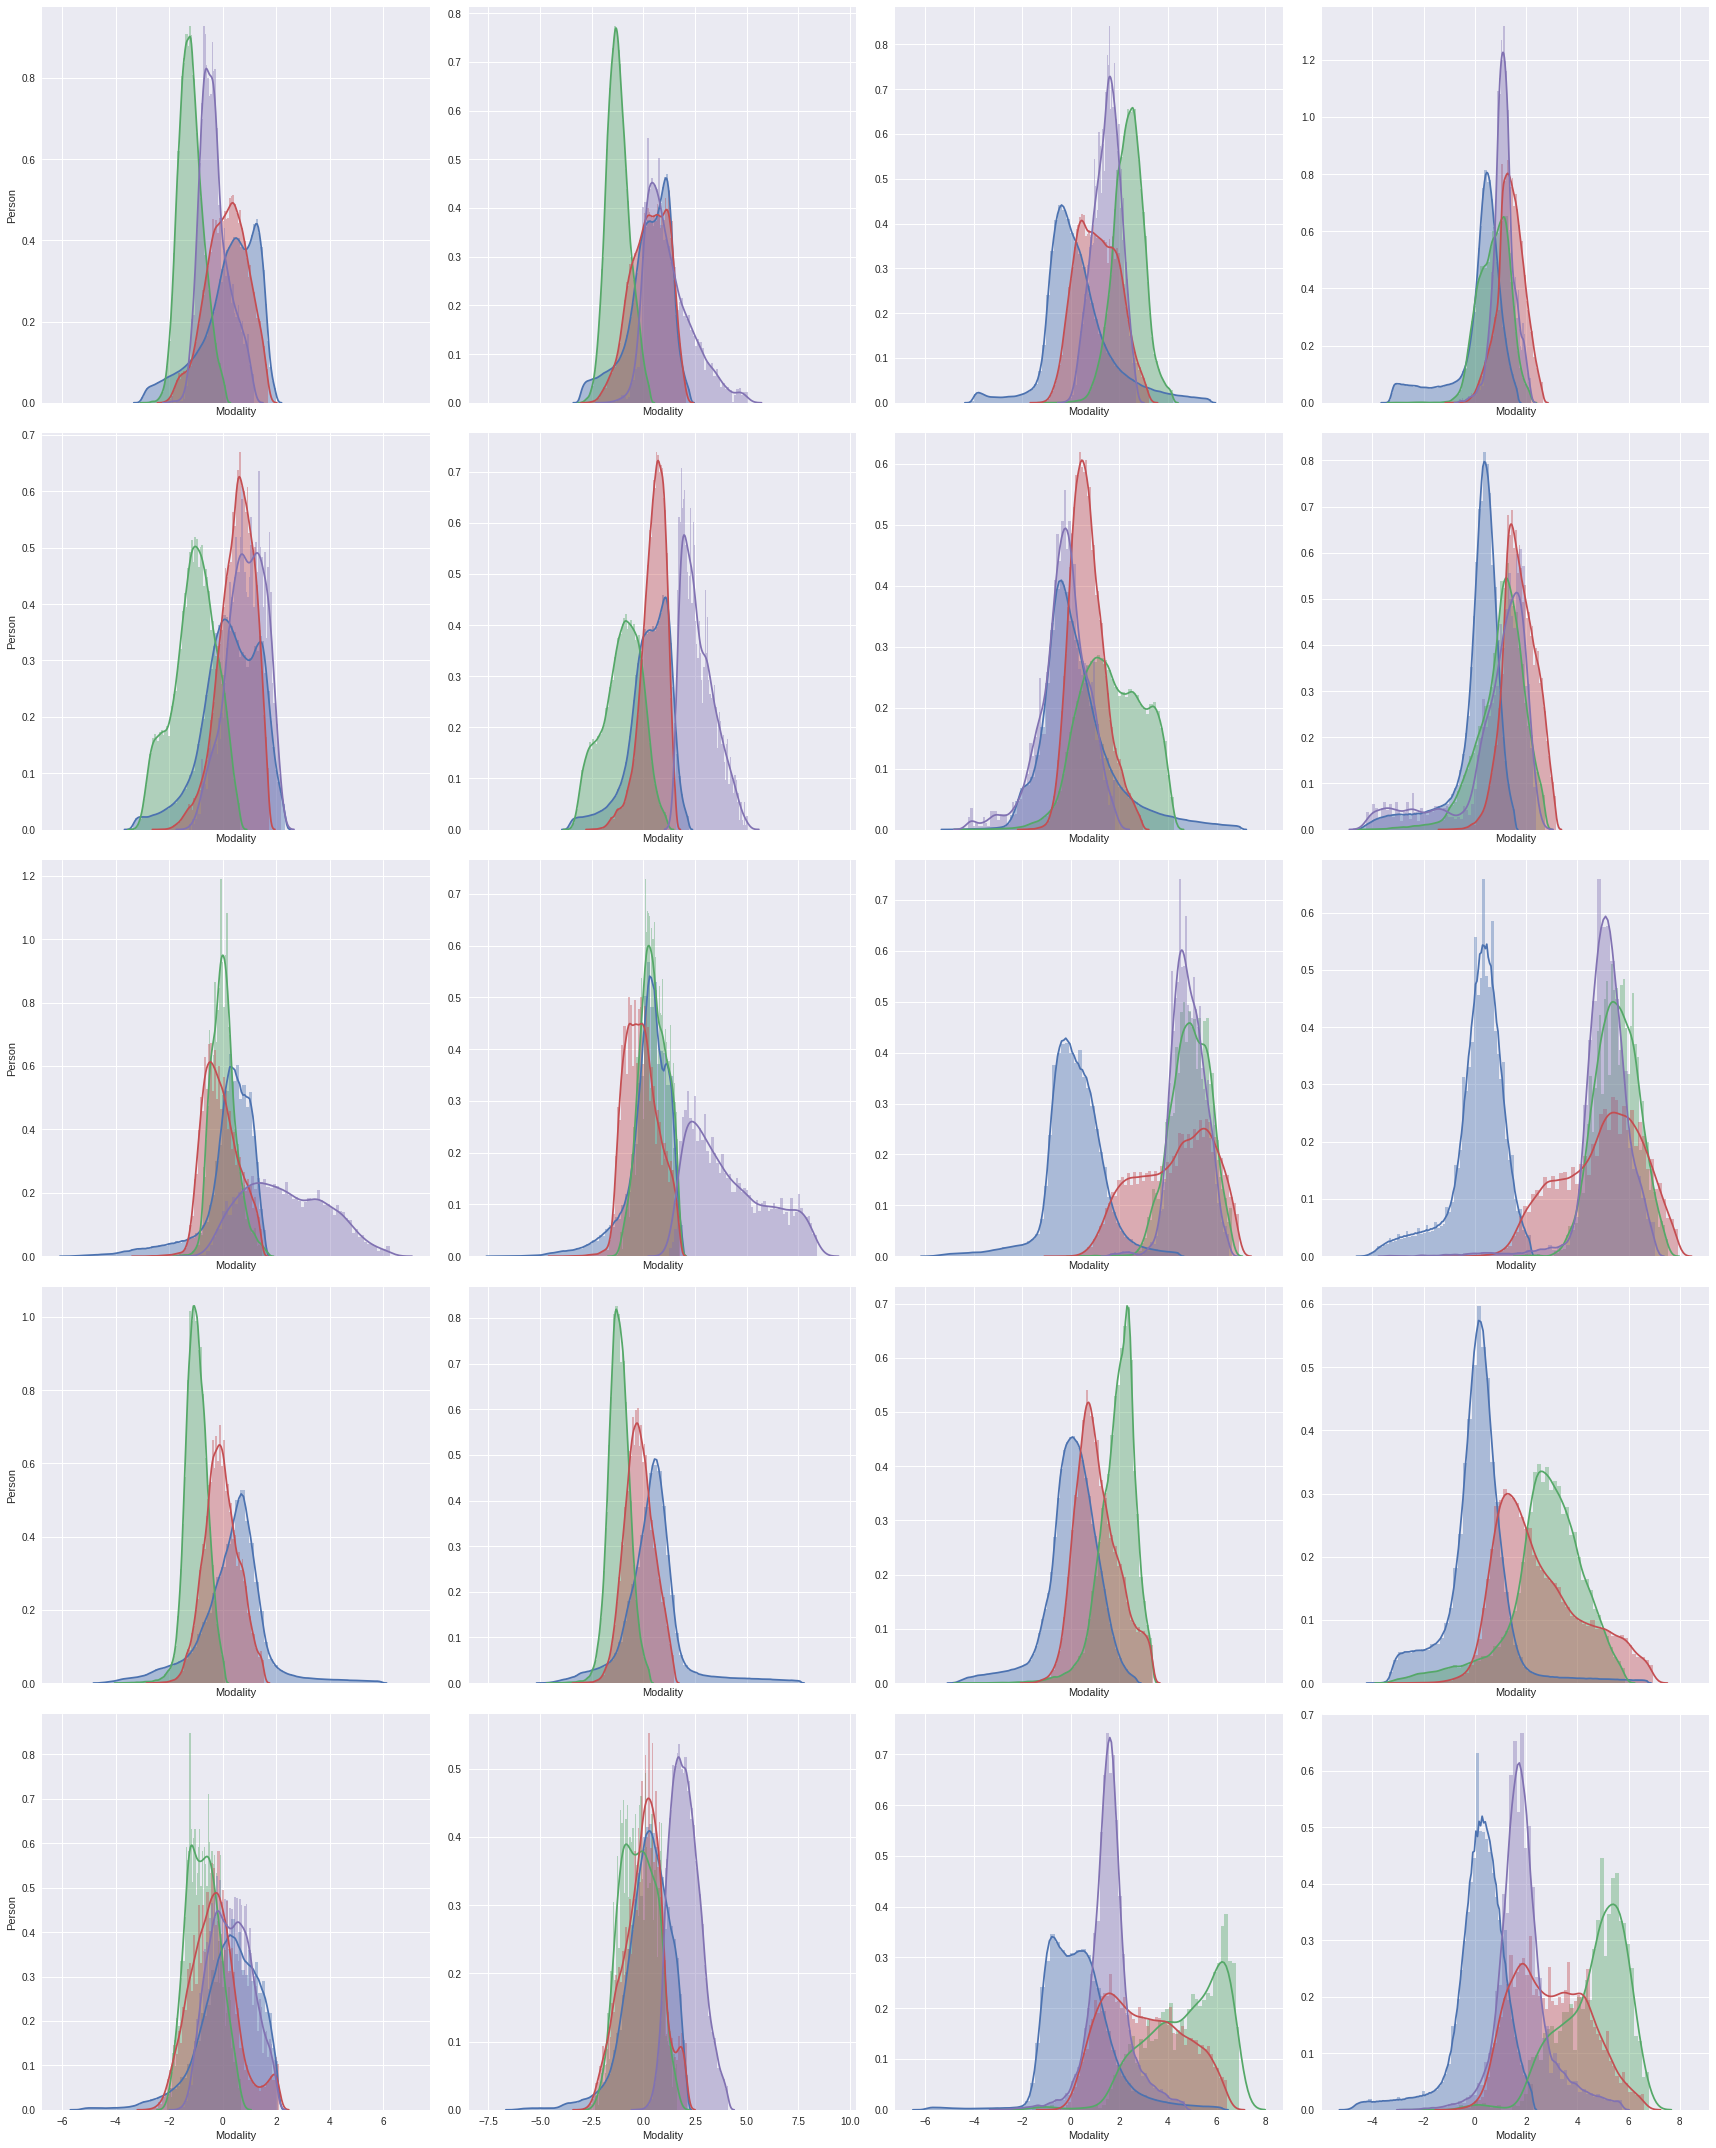

In [9]:
n_mscans = 5
n_modals = 4
fig, ax = plt.subplots(n_mscans, n_modals, figsize=(6*n_modals, 6*n_mscans),
                       sharex='col')

for i in tqdm(range(n_mscans)):
    ax[i, 0].set_ylabel('Person')
    mscan = normalize_scan(mscans[i])
    for j in range(n_modals):
        ax[i, j].set_xlabel('Modality')
        show_hist_stats(normalize_scan(mscans[i][j]), segmentations[i], show=False, ax=ax[i, j])
plt.tight_layout()
plt.show()

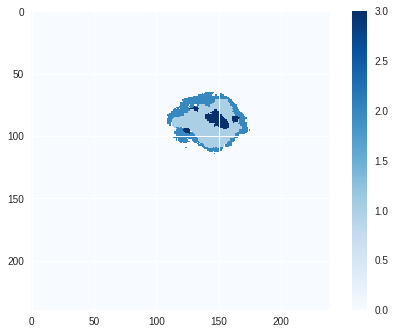

In [10]:
plt.imshow(segmentations[0][..., 60], cmap=cm.Blues)
plt.colorbar()

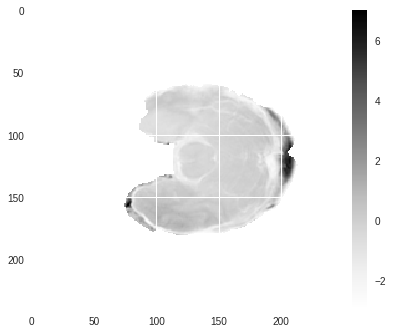

In [91]:
plt.imshow(normalize_scan(mscans[3])[0, ..., 40])
plt.colorbar()

In [96]:
stats = []

def get_size(scan, axis):
    return np.max(np.sum(scan, axis=axis))
    
for patient in tqdm(data_loader.patients):
    mscan = data_loader.load_mscan(patient)
    segmentation = data_loader.load_segmentation(patient)
    
    bottom = scan.min()
    brain = np.any(mscan != bottom, axis=0)
    
    brain_sizes = [get_size(brain, i) for i in range(3)]
    brain_volume = np.sum(brain)
    
    brain_limits = []
    for i in range(3):
        ni = np.arange(3)
        ni = ni[ni != i]
        lim = np.arange(brain.shape[i])[np.any(brain, axis=tuple(ni))][[0, -1]]
        brain_limits.append(list(lim))
        
    cancer = segmentation > 0
    cancer_sizes = [get_size(cancer, i) for i in range(3)]
    cancer_volume = np.sum(cancer)
    
    record = {'patient': patient,
              'brain_x_size': brain_sizes[0],
              'brain_y_size': brain_sizes[1],
              'brain_z_size': brain_sizes[2],
              'brain_limits': brain_limits,
              'cancer_x_size': cancer_sizes[0],
              'cancer_y_size': cancer_sizes[1],
              'cancer_z_size': cancer_sizes[2],
              'brain_volume': brain_volume,
              'cancer_volume': cancer_volume,
              'lgg_cancer': patient in data_loader.lgg_patients
             }
    stats.append(record)

100%|██████████| 285/285 [02:46<00:00,  1.96it/s]


In [97]:
stats = pd.DataFrame(stats)
stats.to_csv('scan_stats.csv')

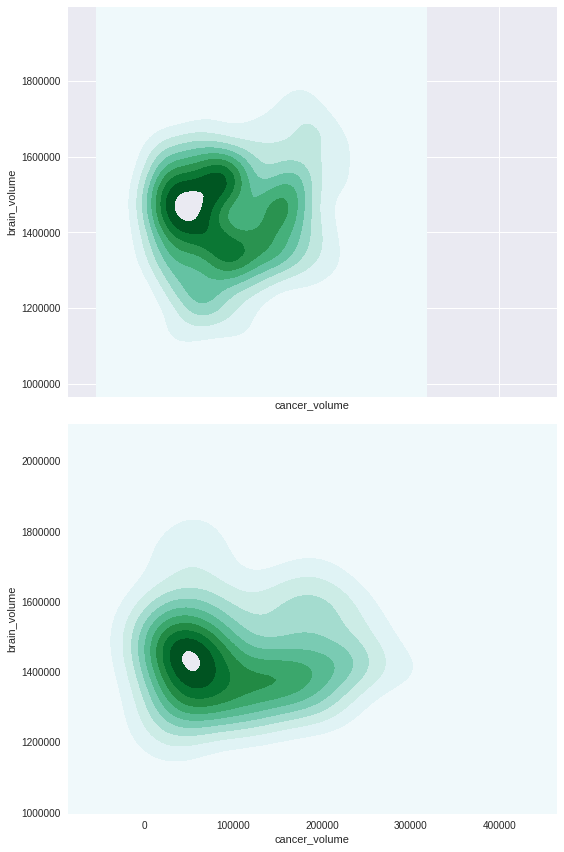

In [98]:
fig, ax = plt.subplots(2, figsize=(8, 12), sharex=True)

for i in range(2):
    subset = stats[stats.lgg_cancer == i]
    sns.kdeplot(subset['cancer_volume'], subset['brain_volume'], shade=True, ax=ax[i])

plt.tight_layout()
plt.show()

In [99]:
brain.shape

(240, 240, 155)

In [126]:
limits = np.array(list(stats.brain_limits.values))

In [130]:
top_limit = limits[..., 1].max(axis=0)
bottom_limit = limits[..., 0].min(axis=0)

In [134]:
top_limit - bottom_limit

array([156, 191, 148])

In [133]:
def squeeze(mscan, segmentation, limits=[154, 187, 149]):
    brain = np.any(mscan, axis=0)    
    for i in range(3):
        ni = np.arange(3)
        ni = ni[ni != i]
        brain_lim = np.arange(brain.shape[i])[np.any(brain, axis=tuple(ni))][[0, -1]]
    
    

(array([196, 220, 148]), array([40, 29,  0]))

(array([  1.,   2.,   9.,  33.,  54.,  80.,  58.,  37.,   8.,   3.]),
 array([ 116. ,  119.8,  123.6,  127.4,  131.2,  135. ,  138.8,  142.6,
         146.4,  150.2,  154. ]),
 <a list of 10 Patch objects>)

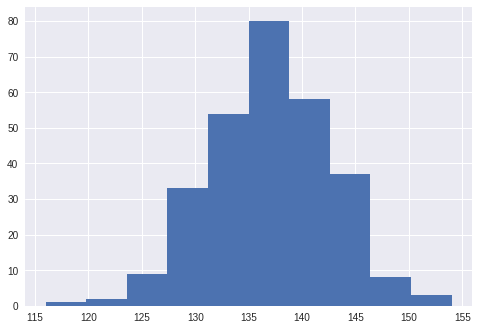

In [76]:
plt.hist(stats.brain_x_size)

In [75]:
for patient in patients:
    mscan = data_loader.load_mscan(patient)
    segmented = data_loader.load_segmentation(patient)

18660